In [8]:
import pandas as pd
import numpy as np
from math import atan2, cos, sin, pi, sqrt
import matplotlib.pyplot as plt

In [35]:
cm_to_m = 0.01
deg_to_rad = pi/180.

dist = 50*cm_to_m
targets = [
    (  dist,     0 ),
    (     0,  dist ),
    (  dist,  dist ),
    ( -dist,  dist ),
    (     0, -dist ),
    ( -dist, -dist ),
    ( -dist,     0 ),
    (  dist, -dist ),
    (     0,     0 ),
]

target_idx = 0

fsm_rad = 8*deg_to_rad
wheel_speed = 3

track_width = 20*cm_to_m
wheel_radius = 3*cm_to_m

x = [0.]
z = [0.]
θ = [0.]

dt = 0.1

dt_ms = int(dt * 1000)
t_ms = 0
tstop_ms = 60 * 1000

ta = [0.]
td = [0.]
wls = [0.]
wrs = [0.]
vs = [0.]

tis = []

while t_ms < tstop_ms:
        
    xt = x[-1]
    zt = z[-1]
    θt = θ[-1]
    
    # Update control based on target
    
    tx, tz = targets[target_idx]
    target_dist = sqrt((tx - xt)**2 + (tz - zt)**2)
    td.append(target_dist)
        
    rx, rz = cos(θt), sin(θt)
    r2tx, r2tz = tx - xt, tz - zt
    
    a = atan2(r2tz, r2tx) - atan2(rz, rx)
    a -= 2*pi if a > pi else 0
    a += 2*pi if a < -pi else 0
    target_angle = a
    
    ta.append(target_angle)

    if target_dist < 10*cm_to_m:
        target_idx = (target_idx + 1) % len(targets)
        tis.append(int(t_ms/dt_ms))
        print('hit target')

    # Wheel speeds are in rads/s
    if -fsm_rad < target_angle < fsm_rad:
        wl = wheel_speed
        wr = wheel_speed
    elif target_angle < -fsm_rad:
        wl = wheel_speed
        wr = -wheel_speed
    else:
        wl = -wheel_speed
        wr = wheel_speed
        
    wls.append(wl)
    wrs.append(wr)
    
    vs.append((wl + wr)/2)

    # Step forward in time
    t_ms += dt_ms
    dx = (wheel_radius/2)*(wl + wr)*cos(θt)*dt
    dz = (wheel_radius/2)*(wl + wr)*sin(θt)*dt
    dθ = (wheel_radius/track_width)*(wr - wl)*dt
    
    θt1 = θt + dθ
    if θt1 > pi:
        θt1 -= 2*pi
    elif θt1 < -pi:
        θt1 += 2*pi
    
    x.append(xt + dx)
    z.append(zt + dz)
    θ.append(θt1)
    
df = pd.DataFrame({
    'x': x,
    'z': z,
    'θ': θ,
    'ta': ta,
    'td': td,
    'wl': wls,
    'wr': wrs,
    'vs': vs
})

print(len(x), tis, len(tis))

hit target
hit target
hit target
hit target
hit target
hit target
hit target
601 [45, 134, 198, 325, 460, 523, 587] 7


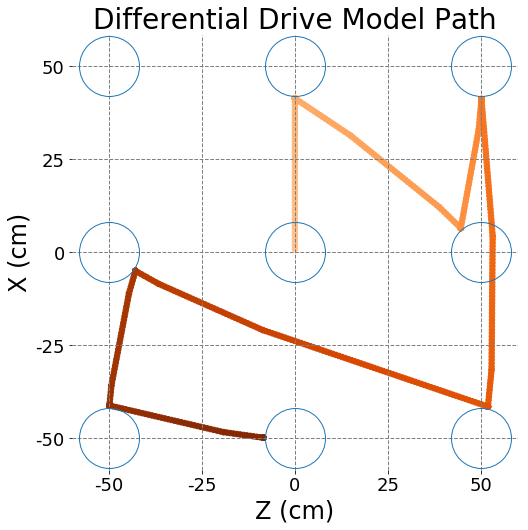

In [36]:
colors = np.linspace(0.3, 1, len(x))
colors[0] = 0
ax = df.plot.scatter('z', 'x', 
                     c=colors, colormap='Oranges', colorbar=False,
                     s=30, 
                     figsize=(8,8))

tgts = np.array(targets)
ax.plot(tgts[:,0], tgts[:,1], 'o', markerfacecolor='none', markersize=60)

ax.axis('equal');
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.grid(color='gray', linestyle='--', linewidth=1);

title_fs = 28
label_fs = 24
tick_fs = 18

ax.set_ylabel('X (cm)', fontsize=label_fs)

ax.set_ylim([-0.6, 0.6]);
ax.set_yticks([-.5, -.25, 0, .25, .5])
ax.set_yticklabels([-50, -25, 0, 25, 50], fontsize=tick_fs);

ax.set_xlabel('Z (cm)', fontsize=label_fs)

ax.set_xlim([-0.6, 0.6]);
ax.set_xticks([-.5, -.25, 0, .25, .5])
ax.set_xticklabels([-50, -25, 0, 25, 50], fontsize=tick_fs);

ax.set_title('Differential Drive Model Path', fontsize=title_fs);
fig = plt.gcf()

In [37]:
fig.savefig('ddm-path.png', bbox_inches='tight')

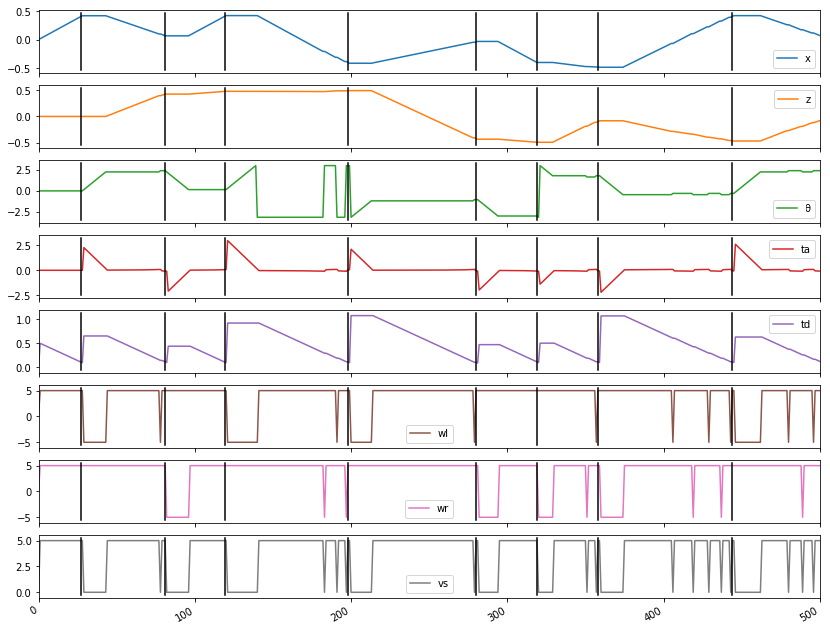

In [125]:
axs = df.plot(subplots=True, figsize=(14, 12));
for ax in axs:
    ylims = ax.get_ylim()
    for ti in tis:
        ax.plot([ti, ti], ylims, color='k')